## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


**I'll be working with Onegin text**

In [ ]:
import string
import os

### Data loading: Shakespeare


In [ ]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/21f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

--2021-12-10 13:56:01--  https://raw.githubusercontent.com/girafe-ai/ml-mipt/21f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 119748 (117K) [text/plain]
Saving to: ‘sonnets.txt’

sonnets.txt         100%[===================>] 116.94K  --.-KB/s    in 0.002s  

2021-12-10 13:56:01 (50.4 MB/s) - ‘sonnets.txt’ saved [119748/119748]



In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [ ]:
# Join all the strings into one and lowercase it
# Put result into variable text.

text = ''.join(word.lower() for word in text)

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


Put all the characters, that you've seen in the text, into variable `tokens`.

In [ ]:
tokens = set()

for token in text:
  tokens.update(set(token))

tokens = list(tokens)
amt_tokens = len(tokens)

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [ ]:
# dict <index>:<char>
idx_to_token = {idx: token for idx, token in enumerate(tokens)}

# dict <char>:<index>
token_to_idx = {token: idx for idx, token in enumerate(tokens)}

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [ ]:
import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
from IPython.display import clear_output

Plot the loss function (axis X: number of epochs, axis Y: loss function).

In [ ]:
def get_substrings(str_, substr_len=64, n_strings=32):
    strings = []
    for i in range(n_strings):
        idx = random.randrange(0, len(str_) - substr_len + 1)
        strings.append(str_[idx:(idx + substr_len)])
    return strings


In [ ]:
def text_to_matrix(text, dtype='int32', batch_first = True):
    text_ix = np.zeros([len(text), len(text[0])], dtype)

    for i in range(len(text)):
        line_ix = [token_to_idx[c] for c in text[i]]
        text_ix[i, :len(line_ix)] = line_ix

    if not batch_first: # convert [batch, time] into [time, batch]
        text_ix = np.transpose(text_ix)

    return text_ix

In [ ]:
class CharRNNCell(nn.Module):
    def __init__(self, num_tokens=amt_tokens, emb_size=128, rnn_num_units=256):
        super(self.__class__, self).__init__()
        self.num_units = rnn_num_units

        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.RNN(emb_size, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x):
        assert isinstance(x.data, torch.LongTensor)
        h_seq, _ = self.rnn(self.emb(x))
        next_logits = self.hid_to_logits(h_seq)
        return next_logits

In [ ]:
model = CharRNNCell()
opt = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

In [ ]:
def train_net(model, text, criterion, n_epoch):
     loss_history = []
     for i in range(n_epoch):
        batch_ix = text_to_matrix(get_substrings(text))
        batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

        logp_seq = model(batch_ix)
        predictions_logp = logp_seq[:, :-1] 
        actual_next_tokens = batch_ix[:, 1:] 

        loss = criterion(
            predictions_logp.contiguous().view(-1, amt_tokens),
            actual_next_tokens.contiguous().view(-1))

        loss.backward()
        opt.step()
        opt.zero_grad()
        
        loss_history.append(loss.data.numpy())

        if (i+1)%100==0:
          clear_output(True)
          plt.figure(figsize=(17, 8))
          plt.plot(loss_history, label='loss')
          plt.xlabel('iterations')
          plt.legend(fontsize=12)
          plt.show()

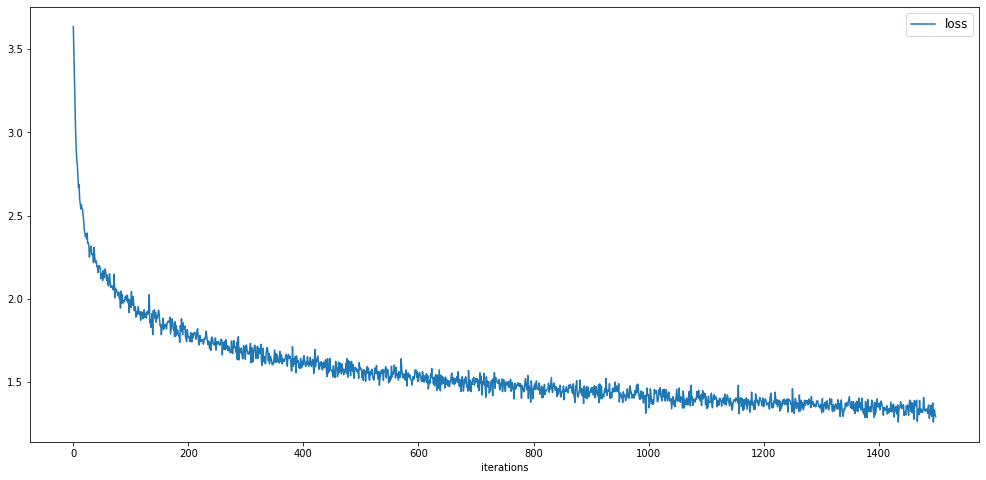

In [ ]:
train_net(model, text, criterion, 1500)

In [ ]:
def generate_sample(char_rnn, seed_phrase=' ', max_length=16, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        out = char_rnn(x_sequence[:, i].view(1, -1))
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        out = char_rnn(x_sequence[:, -1].view(1, -1))
        p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0][0]
        
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [ ]:
generate_sample(model, seed_phrase=' helicopter', temperature=0.7)

' helicopter  wed'

### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [ ]:
class CharLSTMLoop(nn.Module):
    def __init__(self, num_tokens=amt_tokens, emb_size=128, rnn_num_units=256):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.LSTM(emb_size, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x):
        assert isinstance(x.data, torch.LongTensor)
        h_seq, _ = self.rnn(self.emb(x))
        next_logits = self.hid_to_logits(h_seq)
        return next_logits

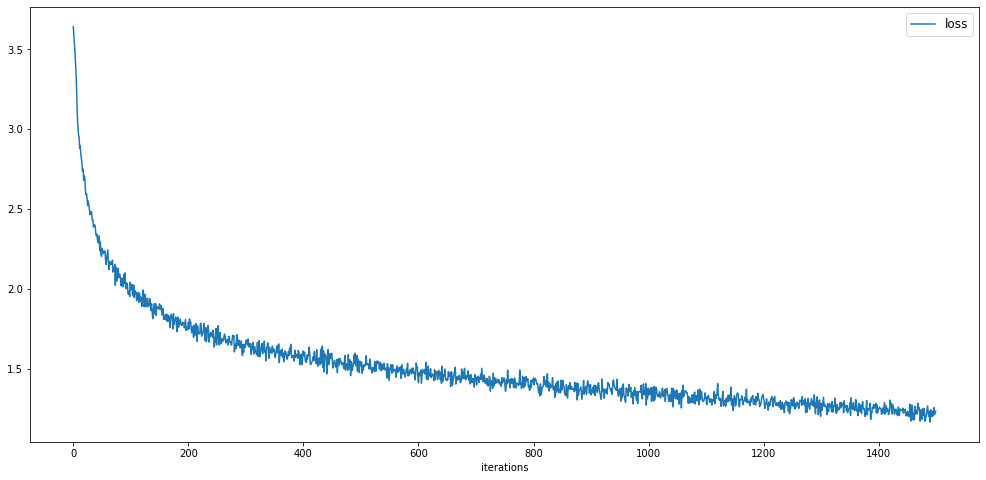

In [ ]:
lstm_model = CharLSTMLoop()
opt = torch.optim.Adam(lstm_model.parameters())
criterion = nn.CrossEntropyLoss()

train_net(lstm_model, text, criterion, 1500)

to me both lstm and vanilla rnn look pretty much the same

but probably with other data(and even now) lstm is slightly better

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [ ]:
print(generate_sample(lstm_model, seed_phrase='helicopter', max_length=500, temperature=1.0))

helicoptersthe tune,  t tonofiten in.
 bl ulle atu:
 blllazeng h withan tt ladsise atask  lo,
 'stckeace, ineme  at.
 thas ceth y myinkenwher w;
 ond sthifathothe  w perm wi) pem lllline wh the onor whingr  ouwathit mayowindstho hee:
, se thar'd'es indent tee icis  wive slt ile
 m'd  thenes illi r  bje t tinouturye ke omese thes he, cyoundi ild:
 otwis:
 qug  titomy 's anch.?
 th.
 au oubouly at  icre s t  t  tour.
 torowon;
 in,
 pr win'swreverireprishetimarost sene,
    imovevo thes sot:
  or,


In [ ]:
temperatures = [0.1, 0.2, 0.5, 1.0, 2.0]
for temp in temperatures:
    print('Generated text for temperature = {}'.format(temp))
    print(generate_sample(lstm_model, seed_phrase='helicopter', max_length=500, temperature=temp))
    print('\n')

Generated text for temperature = 0.1
helicoptere the the the the the the the the the the the the the  the the the the the the the the the the the the the the the the thand the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the than the the the the the the the the the the the the the the the the the the the the the the the thand the the the the the the  the the the the the the the the the the the the the t


Generated text for temperature = 0.2
helicoptere the the the the the the thathe the thand the wind  the the the the the the  the  the the me the the thare thathe  thes the the the  the s the the the the the the the the the the the the the the thand the the whe  the the than the the the the  thes bure the the f the  thand the the thalithe the the t   the the the the the thallll the the t sthe the the the thare t the the the the  thathand the the t the the t

Let's have a look at the generated texts. 

With temperature 0.1 we don't get a text, it's more of a set of the most common words("the" article is the most popular in English, BAM)

But temperature = 2.0 isn't much better: just some random symbols and sometimes words

I would prefer temperatures 0.5 or 1.0 as the most "texty"

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [ ]:
torch.save(lstm_model.state_dict(), 'checkpoint.pth')

new_model = CharLSTMLoop()
new_model.load_state_dict(torch.load('checkpoint.pth'))

<All keys matched successfully>

In [ ]:
new_model.eval()

CharLSTMLoop(
  (emb): Embedding(38, 128)
  (rnn): LSTM(128, 256, batch_first=True)
  (hid_to_logits): Linear(in_features=256, out_features=38, bias=True)
)

In [ ]:
print(generate_sample(new_model, seed_phrase='helicopter', max_length=500, temperature=0.75))

helicopterothecharpl gllly t  we.
  t st thor bando ofanchoufoneary t d pinghthang blindi  tsto  esonouro,
 wi tit this fofo twins t spire the hamis hathe ime  inco mend fet lo hou becre stin s th lxvelestupy  tendr w) s'dst thas'd soveese seno,  tho foth te,
  ind med wafonf touleses lof sar over  cr thasto  rendo f bee tuchathan  te besalalarourishandinge inthar s s theend th asatilk by ng t flll ifalee whe bes, fashes thendr, n aty  thaste orers mye llin,
  in ing llff f boge thin'd,
 suld fr


### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)